Hello this is Jensen's branch

In [3]:
!pip install numpy; random; matplotlib; scipy

zsh:1: command not found: random
zsh:1: command not found: matplotlib
zsh:1: command not found: scipy


In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [5]:
rng = rng = np.random.default_rng(seed=42)

In [6]:
import numpy as np

def gillespie(initial, beta, gamma, mu, max_time, rng):
    S, I, R = initial

    # initialize
    SIR_states = [[S, I, R]]
    timestamps = [0.0]

    events = np.array([
        [ 1,  0,  0],   # Birth
        [-1, +1,  0],   # Infection
        [ 0, -1, +1],   # Recovery
        [-1,  0,  0],   # Death S
        [ 0, -1,  0],   # Death I
        [ 0,  0, -1]    # Death R
    ])

    while timestamps[-1] < max_time and (S+I+R) > 0:
        N = S + I + R

        event_rates = np.array([
            mu * N,
            beta * S*I/N if N > 0 else 0,
            gamma * I,
            mu * S,
            mu * I,
            mu * R
        ])

        # Draw random uniforms for each event
        U = rng.random(len(event_rates))

        # Compute waiting times (τ_i = -log(U_i)/rate_i)
        dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)

        dt_min = np.min(dt_list)
        event = np.argmin(dt_list)

        if dt_min == np.inf:
            break

        # Update time
        timestamps.append(timestamps[-1] + dt_min)

        # Update state
        dS, dI, dR = events[event]
        S, I, R = max(0, S+dS), max(0, I+dI), max(0, R+dR)

        SIR_states.append([S,I,R])

    return np.array(timestamps), np.array(SIR_states)


In [7]:
def SIR_demography(y, t, N, beta, gamma, mu):
    '''SIR model with demography'''
    
    dSdt = mu - beta*y[0]*y[1] - mu*y[0]
    dIdt = beta*y[0]*y[1] - gamma*y[1] - mu*y[1]
    dRdt = gamma*y[1] - mu*y[2]
    
    return [dSdt, dIdt, dRdt]

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_77490/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


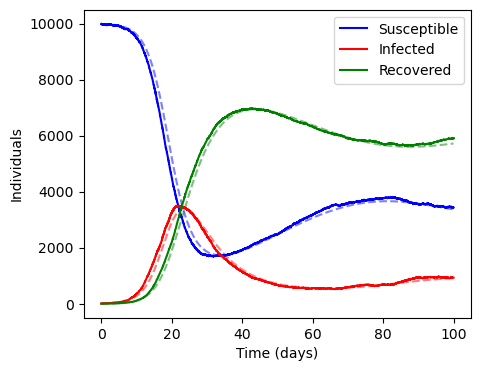

In [8]:
# Define population parameters
N = 10000
I0 = 10

# Define model parameters
beta = 1/2
gamma = 1/7
mu = 0.02

# Duration of simulation
days = 100

# Parameters for gillepsie algorithm
initial = [N-I0, I0, 0]
event_rates = [mu, beta, gamma, mu, mu, mu]

# Run gillepsie algorithm
time, values = gillespie(initial, beta, gamma, mu, 100, rng)

# Gather values over time for each compartment
susceptible = [event[0] for event in values]
infected = [event[1] for event in values]
recovered = [event[2] for event in values]

# Inital parameters deterministic model
y0 = [(N-I0)/N, I0/N, 0]

# Determine timesteps and resolution
t = np.linspace(0, days, 1001)

# Get deteministic solution
solution = odeint(SIR_demography, y0, t, args=(N, beta, gamma, mu))

# Plot data
fig = plt.figure(figsize=(5,4))

# Plot deteministic model
plt.plot(t, solution[:,0] * 10000,'b--', alpha=0.5)
plt.plot(t, solution[:,1] * 10000,'r--', alpha=0.5)
plt.plot(t, solution[:,2] * 10000,'g--', alpha=0.5)

# Plot gillepsie model
plt.plot(time, susceptible, 'b-', label=r'Susceptible')
plt.plot(time, infected, 'r-', label=r'Infected')
plt.plot(time, recovered, 'g-', label=r'Recovered')

plt.ylabel('Individuals')
plt.xlabel('Time (days)')
plt.legend(loc='best')
plt.show()

In [123]:
def gillespie_runs(initial, betas, gammas, mu, n_runs, max_time, rng):
    # initialize lists 
    all_S, all_I =  [], []
    S0, I0, R0 = initial
    N = S0 + I0 + R0

    interpolation_grid = np.linspace(0, max_time, 1000)

    for gamma in gammas:
        for beta in betas:
            run_S, run_I =[], []

            for _ in range(n_runs):
                t, SIR = gillespie(initial, beta, gamma, mu, max_time, rng)
                S, I, R = SIR.T

                # Interpolate to common time grid
                S_interp = np.interp(interpolation_grid, t, S)
                I_interp = np.interp(interpolation_grid, t, I)

                run_S.append(S_interp)
                run_I.append(I_interp)

            all_S = np.array(run_S)
            all_I = np.array(run_I)
            S_mean = all_S.mean(axis=0)
            I_mean = all_I.mean(axis=0)

            solution = odeint(SIR_demography, initial, interpolation_grid, args=(N, beta, gamma, mu))
            S_d, I_d, R = solution.T

            plt.figure(figsize=(10, 5))
            
            
            # plot all stochastic infection trajectories
            for S in all_S:
                 plt.plot(interpolation_grid, S, color='black', alpha=0.3)
                 
            for I_run in all_I:
                plt.plot(interpolation_grid, I_run, color='gray', alpha=0.3)
            # plot mean infected curve
            plt.plot(interpolation_grid, I_mean, color='red', lw=2, label='Mean I(t)')
            plt.plot(interpolation_grid, S_mean, color='blue', lw=2, label='Mean S(t)')

            plt.plot(interpolation_grid, S_d, 'b--', lw=2, label='S(t) deterministic')
            plt.plot(interpolation_grid, I_d, 'r--', lw=2, label='I(t) deterministic')
            
            plt.xlabel("Time")
            plt.ylabel("Infected individuals")
            plt.title(f"Stochastic Gillespie runs (β={beta}, γ={gamma}, n={n_runs})")
            plt.legend()
            plt.show()

            print(f"β={beta}, γ={gamma}: completed {n_runs} runs.")

    return all_S, all_I
              

In [124]:
def compute_means(all_S, all_I):
    all_S, all_I = np.array(all_S), np.array(all_I)
    S_var, I_var = all_S.var(axis=0), all_I.var(axis=0)
    
    S_mean, I_mean = all_S.mean(axis=0), all_I.mean(axis= 0)

    return S_mean, I_mean, S_var, I_var

/var/folders/py/1fr1xt1s4zg475rpjfmpxbt80000gn/T/ipykernel_77490/2965628816.py:35: RuntimeWarning: divide by zero encountered in divide
  dt_list = np.where(event_rates > 0, -np.log(U) / event_rates, np.inf)


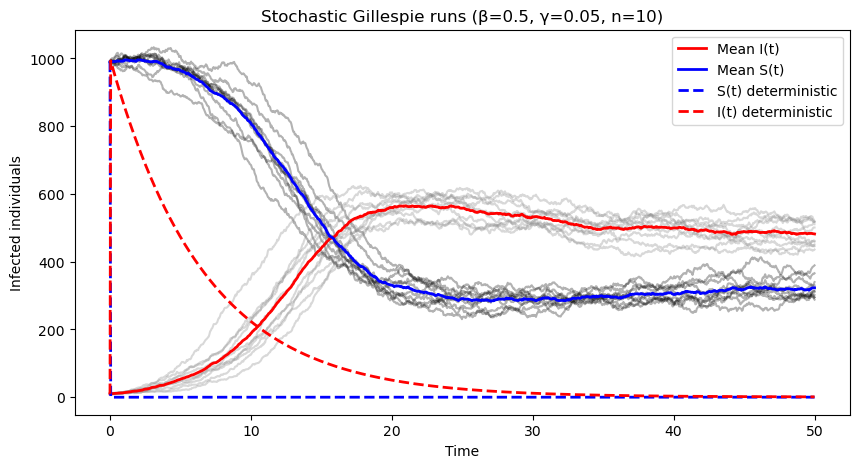

β=0.5, γ=0.05: completed 10 runs.


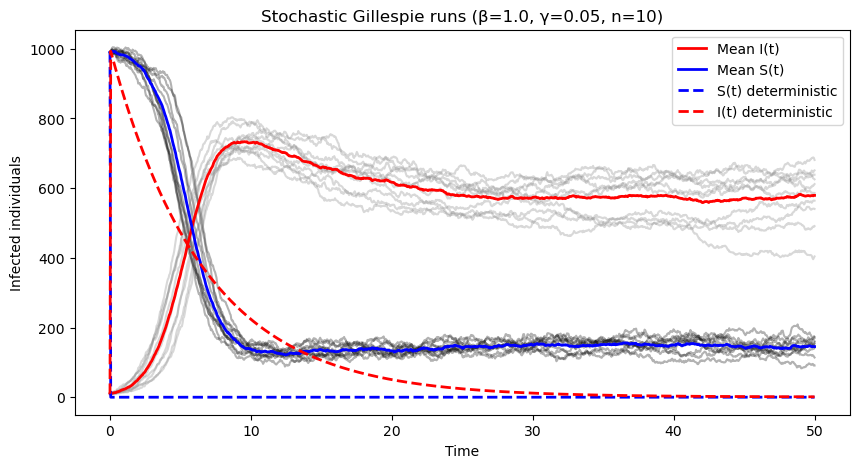

β=1.0, γ=0.05: completed 10 runs.


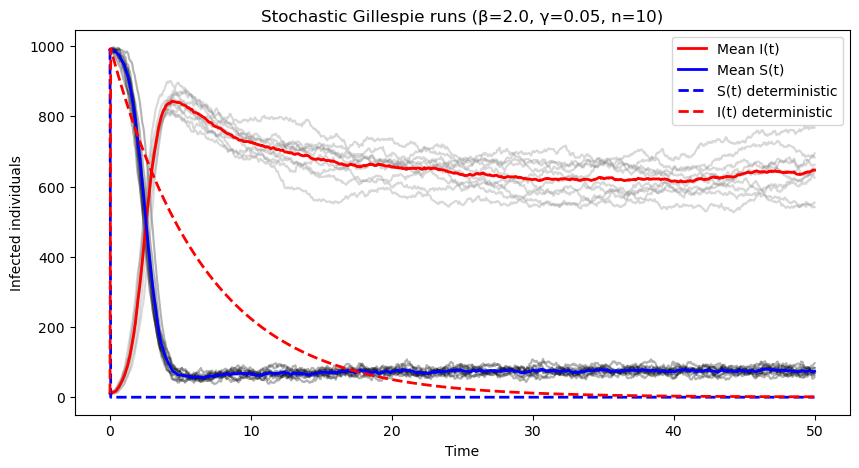

β=2.0, γ=0.05: completed 10 runs.


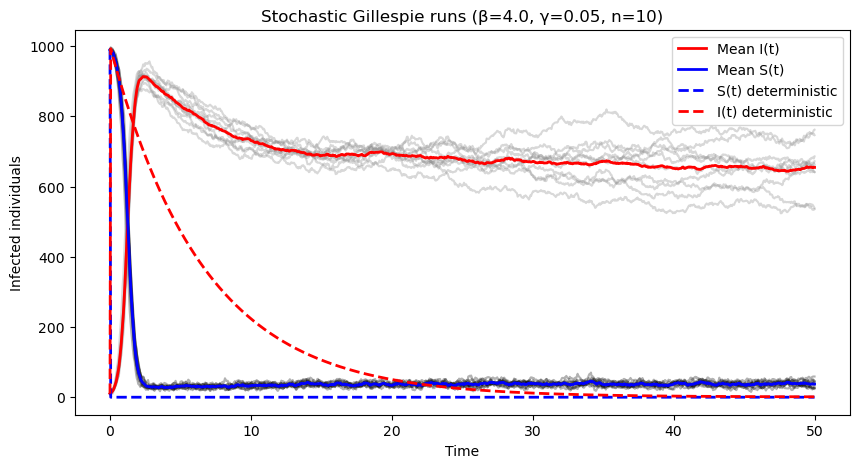

β=4.0, γ=0.05: completed 10 runs.


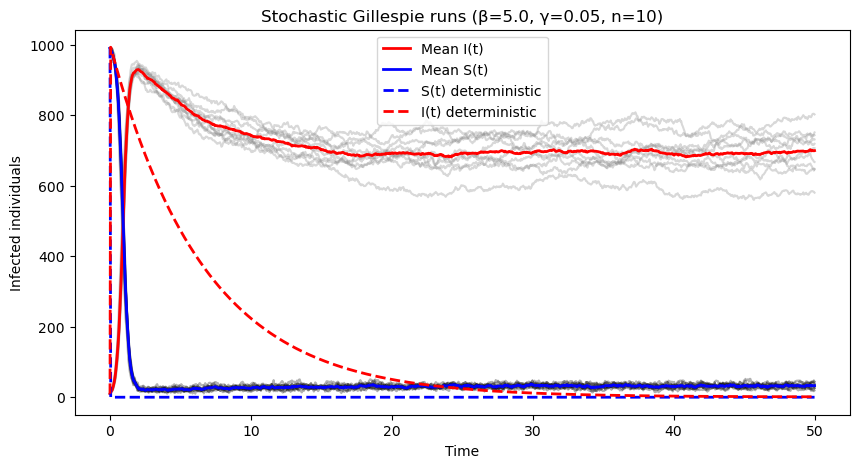

β=5.0, γ=0.05: completed 10 runs.


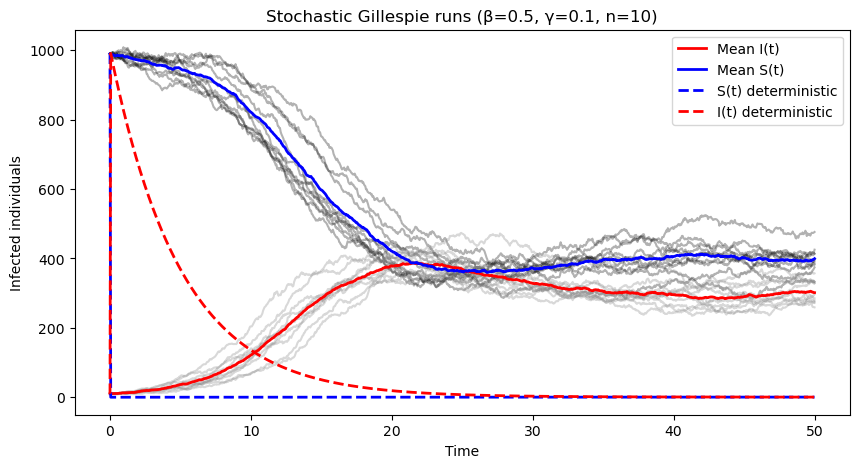

β=0.5, γ=0.1: completed 10 runs.


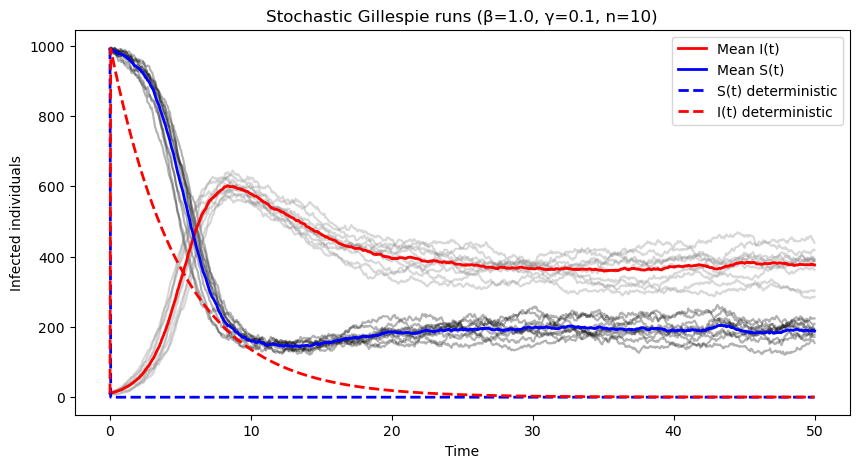

β=1.0, γ=0.1: completed 10 runs.


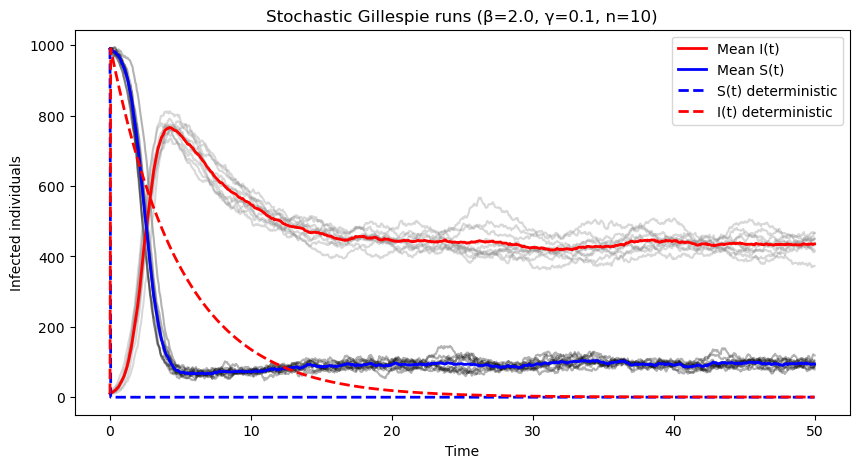

β=2.0, γ=0.1: completed 10 runs.


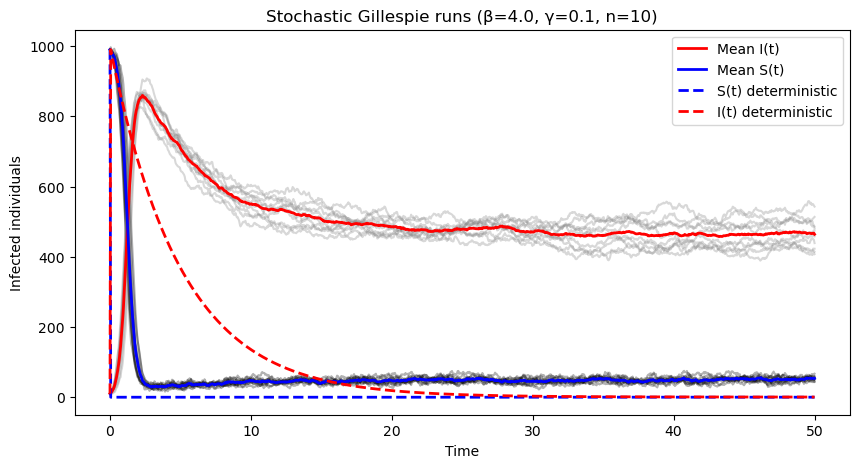

β=4.0, γ=0.1: completed 10 runs.


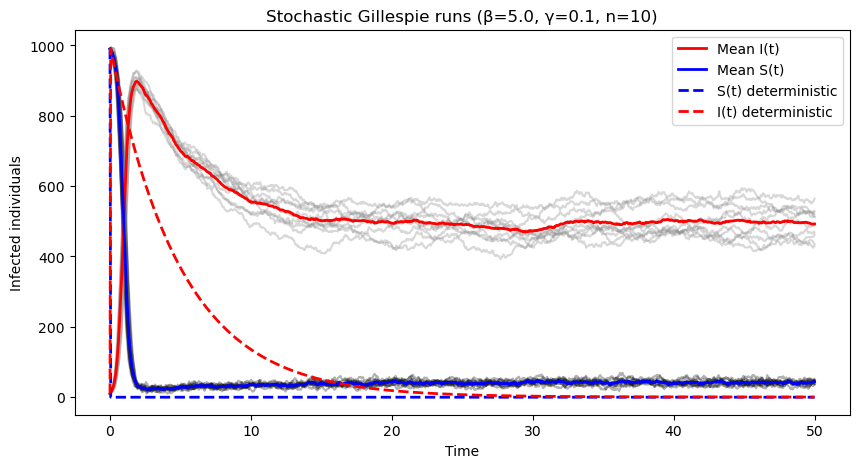

β=5.0, γ=0.1: completed 10 runs.


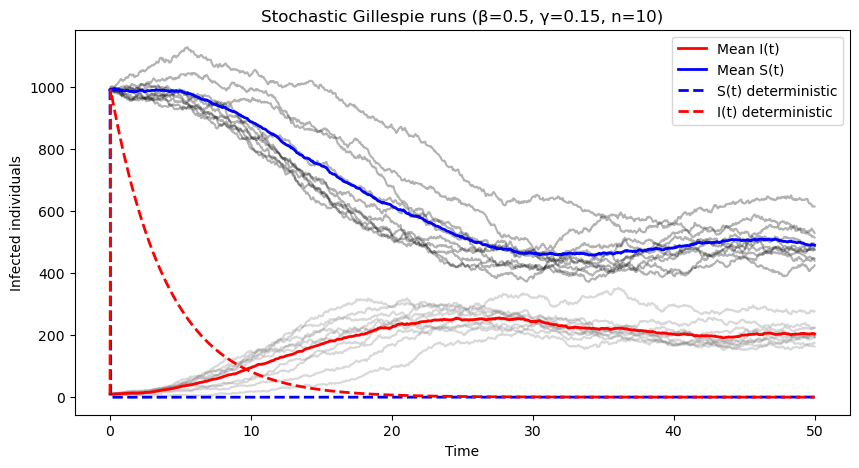

β=0.5, γ=0.15: completed 10 runs.


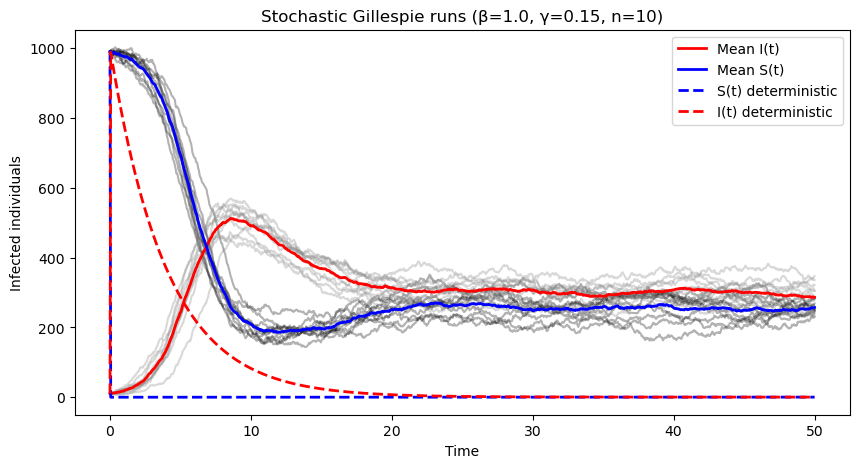

β=1.0, γ=0.15: completed 10 runs.


In [ ]:
rng = np.random.default_rng(42)

# Parameters
initial = (990, 10, 0)
# define variable variation
betas = [0.5, 1.0, 2.0, 4.0, 5.0]
gammas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
mu = 0.1
n_runs = 10
max_time = 50

all_S, all_I = gillespie_runs(initial, betas, gammas, mu, n_runs, max_time, rng)




